# Import Libraries

In [10]:

import os
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from code.classifier import PneumoniaClassifier, Config
from code.plot_random_image import plot_random_image_from_loader
from code.classify_random_images import plot_random_images_with_labels
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt



In [11]:

# Load the TensorBoard
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

# Check GPU Availability

In [13]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Dec  2 19:42:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   44C    P8             13W /  285W |    2634MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup Model

In [14]:
config = Config(
    backbone_name="resnet18",
    transfer_learning=True,
    learning_rate=1e-4,
    batch_size=20,
    max_epochs=50,
    weight_decay=1e-4,
    dropout=0.2,
    num_workers=16,
    model_name="ResNet18_reordered",
    version="001",
    optimizer_name = "sgd",
    use_class_weights=False,
    image_res=224,
    patience = 10,
    image_type=1
)
model = PneumoniaClassifier(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Plot random images from all datasets

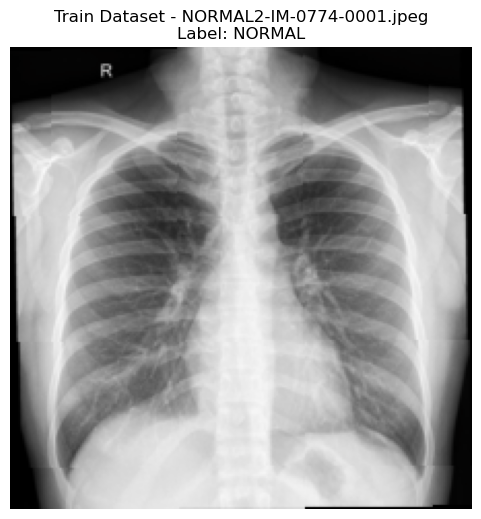

In [15]:
plot_random_image_from_loader(model.train_loader.dataset, "Train Dataset")

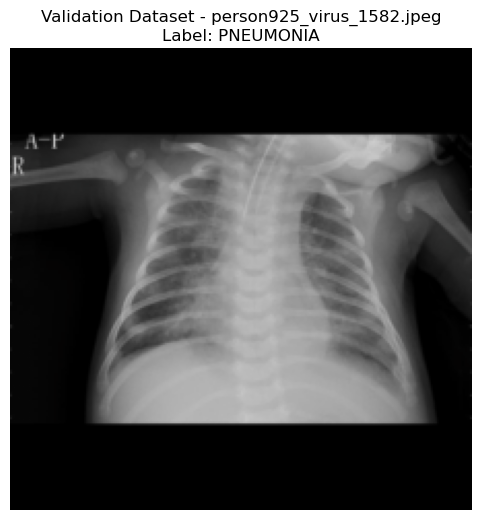

In [16]:
plot_random_image_from_loader(model.val_loader.dataset, "Validation Dataset")

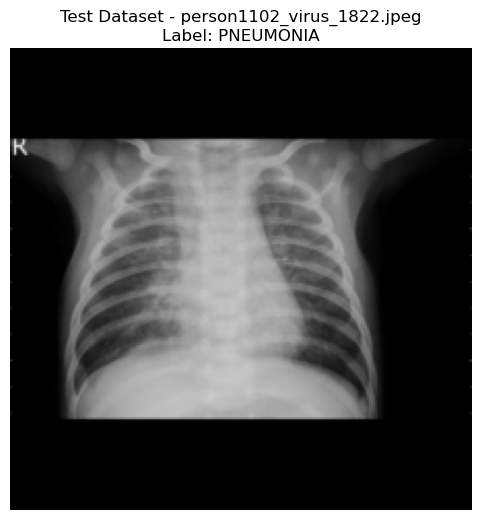

In [17]:
plot_random_image_from_loader(model.test_loader.dataset, "Test Dataset")

# Train Model

In [18]:

# Train Model
model.train_model()
torch.save({
    "state_dict": model.state_dict(),
    "config": config
}, f"../models/{config.model_name}_final.pt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type              | Params | Mode 
----------------------------------------------------------------
0 | accuracy          | BinaryAccuracy    | 0      | train
1 | precision         | BinaryPrecision   | 0      | train
2 | recall            | BinaryRecall      | 0      | train
3 | f1                | BinaryF1Score     | 0      | train
4 | specificity       | BinarySpecificity | 0      | train
5 | feature_extractor | Sequential        | 11.2 M | train
6 | dropout           | Dropout           | 0      | train
7 | classifier        | Linear            | 1.0 K  | train
----------------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 205/205 [00:17<00:00, 12.05it/s, v_num=2, train_loss_step=0.409]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 205/205 [00:21<00:00,  9.49it/s, v_num=2, train_loss_step=0.409, val_acc_epoch=0.787, val_precision_epoch=0.816, val_recall_epoch=0.915, val_f1_epoch=0.863, val_specificity_epoch=0.442]

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 18. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.341


Epoch 1: 100%|██████████| 205/205 [00:16<00:00, 12.22it/s, v_num=2, train_loss_step=0.391, val_acc_epoch=0.787, val_precision_epoch=0.816, val_recall_epoch=0.915, val_f1_epoch=0.863, val_specificity_epoch=0.442]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 205/205 [00:21<00:00,  9.50it/s, v_num=2, train_loss_step=0.391, val_acc_epoch=0.874, val_precision_epoch=0.891, val_recall_epoch=0.943, val_f1_epoch=0.916, val_specificity_epoch=0.687]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.260


Epoch 2: 100%|██████████| 205/205 [00:16<00:00, 12.19it/s, v_num=2, train_loss_step=0.168, val_acc_epoch=0.874, val_precision_epoch=0.891, val_recall_epoch=0.943, val_f1_epoch=0.916, val_specificity_epoch=0.687]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 205/205 [00:21<00:00,  9.60it/s, v_num=2, train_loss_step=0.168, val_acc_epoch=0.887, val_precision_epoch=0.908, val_recall_epoch=0.941, val_f1_epoch=0.924, val_specificity_epoch=0.741]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.250


Epoch 3: 100%|██████████| 205/205 [00:16<00:00, 12.45it/s, v_num=2, train_loss_step=0.132, val_acc_epoch=0.887, val_precision_epoch=0.908, val_recall_epoch=0.941, val_f1_epoch=0.924, val_specificity_epoch=0.741]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 205/205 [00:21<00:00,  9.72it/s, v_num=2, train_loss_step=0.132, val_acc_epoch=0.898, val_precision_epoch=0.916, val_recall_epoch=0.947, val_f1_epoch=0.931, val_specificity_epoch=0.766]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.243


Epoch 4: 100%|██████████| 205/205 [00:16<00:00, 12.07it/s, v_num=2, train_loss_step=0.156, val_acc_epoch=0.898, val_precision_epoch=0.916, val_recall_epoch=0.947, val_f1_epoch=0.931, val_specificity_epoch=0.766]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 205/205 [00:21<00:00,  9.52it/s, v_num=2, train_loss_step=0.156, val_acc_epoch=0.907, val_precision_epoch=0.925, val_recall_epoch=0.950, val_f1_epoch=0.937, val_specificity_epoch=0.792]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.216


Epoch 5: 100%|██████████| 205/205 [00:16<00:00, 12.17it/s, v_num=2, train_loss_step=0.175, val_acc_epoch=0.907, val_precision_epoch=0.925, val_recall_epoch=0.950, val_f1_epoch=0.937, val_specificity_epoch=0.792]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 205/205 [00:21<00:00,  9.47it/s, v_num=2, train_loss_step=0.175, val_acc_epoch=0.908, val_precision_epoch=0.927, val_recall_epoch=0.948, val_f1_epoch=0.938, val_specificity_epoch=0.799]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.206


Epoch 6: 100%|██████████| 205/205 [00:16<00:00, 12.19it/s, v_num=2, train_loss_step=0.160, val_acc_epoch=0.908, val_precision_epoch=0.927, val_recall_epoch=0.948, val_f1_epoch=0.938, val_specificity_epoch=0.799]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 205/205 [00:21<00:00,  9.53it/s, v_num=2, train_loss_step=0.160, val_acc_epoch=0.909, val_precision_epoch=0.925, val_recall_epoch=0.952, val_f1_epoch=0.938, val_specificity_epoch=0.792]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.202


Epoch 7: 100%|██████████| 205/205 [00:16<00:00, 12.61it/s, v_num=2, train_loss_step=0.153, val_acc_epoch=0.909, val_precision_epoch=0.925, val_recall_epoch=0.952, val_f1_epoch=0.938, val_specificity_epoch=0.792]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 205/205 [00:20<00:00,  9.86it/s, v_num=2, train_loss_step=0.153, val_acc_epoch=0.916, val_precision_epoch=0.934, val_recall_epoch=0.953, val_f1_epoch=0.943, val_specificity_epoch=0.817]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.193


Epoch 8: 100%|██████████| 205/205 [00:16<00:00, 12.37it/s, v_num=2, train_loss_step=0.128, val_acc_epoch=0.916, val_precision_epoch=0.934, val_recall_epoch=0.953, val_f1_epoch=0.943, val_specificity_epoch=0.817]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 205/205 [00:21<00:00,  9.70it/s, v_num=2, train_loss_step=0.128, val_acc_epoch=0.912, val_precision_epoch=0.929, val_recall_epoch=0.951, val_f1_epoch=0.940, val_specificity_epoch=0.805]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.190


Epoch 9: 100%|██████████| 205/205 [00:16<00:00, 12.52it/s, v_num=2, train_loss_step=0.173, val_acc_epoch=0.912, val_precision_epoch=0.929, val_recall_epoch=0.951, val_f1_epoch=0.940, val_specificity_epoch=0.805]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 205/205 [00:16<00:00, 12.39it/s, v_num=2, train_loss_step=0.371, val_acc_epoch=0.917, val_precision_epoch=0.934, val_recall_epoch=0.953, val_f1_epoch=0.944, val_specificity_epoch=0.818]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 205/205 [00:21<00:00,  9.64it/s, v_num=2, train_loss_step=0.371, val_acc_epoch=0.919, val_precision_epoch=0.935, val_recall_epoch=0.956, val_f1_epoch=0.945, val_specificity_epoch=0.822]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.187


Epoch 11: 100%|██████████| 205/205 [00:16<00:00, 12.46it/s, v_num=2, train_loss_step=0.109, val_acc_epoch=0.919, val_precision_epoch=0.935, val_recall_epoch=0.956, val_f1_epoch=0.945, val_specificity_epoch=0.822]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 205/205 [00:16<00:00, 12.35it/s, v_num=2, train_loss_step=0.132, val_acc_epoch=0.923, val_precision_epoch=0.939, val_recall_epoch=0.956, val_f1_epoch=0.948, val_specificity_epoch=0.833]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 205/205 [00:21<00:00,  9.68it/s, v_num=2, train_loss_step=0.132, val_acc_epoch=0.919, val_precision_epoch=0.936, val_recall_epoch=0.954, val_f1_epoch=0.945, val_specificity_epoch=0.825]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.185


Epoch 13: 100%|██████████| 205/205 [00:16<00:00, 12.63it/s, v_num=2, train_loss_step=0.239, val_acc_epoch=0.919, val_precision_epoch=0.936, val_recall_epoch=0.954, val_f1_epoch=0.945, val_specificity_epoch=0.825] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 205/205 [00:20<00:00,  9.90it/s, v_num=2, train_loss_step=0.239, val_acc_epoch=0.918, val_precision_epoch=0.934, val_recall_epoch=0.955, val_f1_epoch=0.944, val_specificity_epoch=0.818]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.176


Epoch 14: 100%|██████████| 205/205 [00:16<00:00, 12.31it/s, v_num=2, train_loss_step=0.131, val_acc_epoch=0.918, val_precision_epoch=0.934, val_recall_epoch=0.955, val_f1_epoch=0.944, val_specificity_epoch=0.818]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 205/205 [00:21<00:00,  9.61it/s, v_num=2, train_loss_step=0.131, val_acc_epoch=0.923, val_precision_epoch=0.938, val_recall_epoch=0.958, val_f1_epoch=0.948, val_specificity_epoch=0.828]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.175


Epoch 15: 100%|██████████| 205/205 [00:16<00:00, 12.55it/s, v_num=2, train_loss_step=0.139, val_acc_epoch=0.923, val_precision_epoch=0.938, val_recall_epoch=0.958, val_f1_epoch=0.948, val_specificity_epoch=0.828]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 205/205 [00:16<00:00, 12.51it/s, v_num=2, train_loss_step=0.536, val_acc_epoch=0.922, val_precision_epoch=0.939, val_recall_epoch=0.955, val_f1_epoch=0.947, val_specificity_epoch=0.832]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 205/205 [00:20<00:00,  9.83it/s, v_num=2, train_loss_step=0.536, val_acc_epoch=0.919, val_precision_epoch=0.935, val_recall_epoch=0.956, val_f1_epoch=0.945, val_specificity_epoch=0.819]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.174


Epoch 17: 100%|██████████| 205/205 [00:16<00:00, 12.43it/s, v_num=2, train_loss_step=0.116, val_acc_epoch=0.919, val_precision_epoch=0.935, val_recall_epoch=0.956, val_f1_epoch=0.945, val_specificity_epoch=0.819]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 205/205 [00:16<00:00, 12.41it/s, v_num=2, train_loss_step=0.0822, val_acc_epoch=0.923, val_precision_epoch=0.942, val_recall_epoch=0.954, val_f1_epoch=0.948, val_specificity_epoch=0.841]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 205/205 [00:16<00:00, 12.38it/s, v_num=2, train_loss_step=0.127, val_acc_epoch=0.924, val_precision_epoch=0.939, val_recall_epoch=0.958, val_f1_epoch=0.948, val_specificity_epoch=0.831]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 205/205 [00:16<00:00, 12.45it/s, v_num=2, train_loss_step=0.269, val_acc_epoch=0.927, val_precision_epoch=0.944, val_recall_epoch=0.957, val_f1_epoch=0.951, val_specificity_epoch=0.847]
Validatio

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.167


Epoch 22: 100%|██████████| 205/205 [00:17<00:00, 12.04it/s, v_num=2, train_loss_step=0.107, val_acc_epoch=0.925, val_precision_epoch=0.940, val_recall_epoch=0.959, val_f1_epoch=0.949, val_specificity_epoch=0.835] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 205/205 [00:16<00:00, 12.18it/s, v_num=2, train_loss_step=0.0769, val_acc_epoch=0.926, val_precision_epoch=0.943, val_recall_epoch=0.956, val_f1_epoch=0.950, val_specificity_epoch=0.845]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 205/205 [00:17<00:00, 11.96it/s, v_num=2, train_loss_step=0.260, val_acc_epoch=0.930, val_precision_epoch=0.947, val_recall_epoch=0.958, val_f1_epoch=0.952, val_specificity_epoch=0.855]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 205/205 [00:16<00:00, 12.13it/s, v_num=2, train_loss_step=0.103, val_acc_epoch=0.929, val_precision_epoch=0.944, val_recall_epoch=0.959, val_f1_epoch=0.952, val_specificity_epoch=0.848]
Validati

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.165


Epoch 27: 100%|██████████| 205/205 [00:17<00:00, 11.97it/s, v_num=2, train_loss_step=0.178, val_acc_epoch=0.927, val_precision_epoch=0.943, val_recall_epoch=0.958, val_f1_epoch=0.950, val_specificity_epoch=0.844]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 205/205 [00:21<00:00,  9.44it/s, v_num=2, train_loss_step=0.178, val_acc_epoch=0.927, val_precision_epoch=0.942, val_recall_epoch=0.959, val_f1_epoch=0.950, val_specificity_epoch=0.839]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.164


Epoch 28: 100%|██████████| 205/205 [00:16<00:00, 12.16it/s, v_num=2, train_loss_step=0.134, val_acc_epoch=0.927, val_precision_epoch=0.942, val_recall_epoch=0.959, val_f1_epoch=0.950, val_specificity_epoch=0.839] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 205/205 [00:21<00:00,  9.39it/s, v_num=2, train_loss_step=0.134, val_acc_epoch=0.929, val_precision_epoch=0.947, val_recall_epoch=0.956, val_f1_epoch=0.952, val_specificity_epoch=0.857]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.164


Epoch 29: 100%|██████████| 205/205 [00:16<00:00, 12.12it/s, v_num=2, train_loss_step=0.166, val_acc_epoch=0.929, val_precision_epoch=0.947, val_recall_epoch=0.956, val_f1_epoch=0.952, val_specificity_epoch=0.857]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 205/205 [00:21<00:00,  9.53it/s, v_num=2, train_loss_step=0.166, val_acc_epoch=0.929, val_precision_epoch=0.945, val_recall_epoch=0.958, val_f1_epoch=0.951, val_specificity_epoch=0.849]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.162


Epoch 30: 100%|██████████| 205/205 [00:16<00:00, 12.19it/s, v_num=2, train_loss_step=0.0862, val_acc_epoch=0.929, val_precision_epoch=0.945, val_recall_epoch=0.958, val_f1_epoch=0.951, val_specificity_epoch=0.849]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 205/205 [00:16<00:00, 12.16it/s, v_num=2, train_loss_step=0.360, val_acc_epoch=0.926, val_precision_epoch=0.941, val_recall_epoch=0.958, val_f1_epoch=0.950, val_specificity_epoch=0.837] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 205/205 [00:21<00:00,  9.57it/s, v_num=2, train_loss_step=0.360, val_acc_epoch=0.929, val_precision_epoch=0.943, val_recall_epoch=0.960, val_f1_epoch=0.952, val_specificity_epoch=0.845]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.161


Epoch 32: 100%|██████████| 205/205 [00:16<00:00, 12.28it/s, v_num=2, train_loss_step=0.137, val_acc_epoch=0.929, val_precision_epoch=0.943, val_recall_epoch=0.960, val_f1_epoch=0.952, val_specificity_epoch=0.845]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 205/205 [00:17<00:00, 12.00it/s, v_num=2, train_loss_step=0.166, val_acc_epoch=0.923, val_precision_epoch=0.940, val_recall_epoch=0.955, val_f1_epoch=0.948, val_specificity_epoch=0.836]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 205/205 [00:16<00:00, 12.33it/s, v_num=2, train_loss_step=0.159, val_acc_epoch=0.927, val_precision_epoch=0.944, val_recall_epoch=0.957, val_f1_epoch=0.951, val_specificity_epoch=0.848]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████| 205/205 [00:16<00:00, 12.59it/s, v_num=2, train_loss_step=0.311, val_acc_epoch=0.926, val_precision_epoch=0.941, val_recall_epoch=0.958, val_f1_epoch=0.950, val_specificity_epoch=0.838]
Validation

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.159


Epoch 39: 100%|██████████| 205/205 [00:16<00:00, 12.28it/s, v_num=2, train_loss_step=0.172, val_acc_epoch=0.929, val_precision_epoch=0.945, val_recall_epoch=0.959, val_f1_epoch=0.952, val_specificity_epoch=0.848] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 205/205 [00:17<00:00, 11.98it/s, v_num=2, train_loss_step=0.571, val_acc_epoch=0.927, val_precision_epoch=0.945, val_recall_epoch=0.956, val_f1_epoch=0.951, val_specificity_epoch=0.849]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████| 205/205 [00:17<00:00, 11.98it/s, v_num=2, train_loss_step=0.412, val_acc_epoch=0.931, val_precision_epoch=0.946, val_recall_epoch=0.960, val_f1_epoch=0.953, val_specificity_epoch=0.853]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████| 205/205 [00:21<00:00,  9.32it/s, v_num=2, train_loss_step=0.412, val_acc_epoch=0.936, val_precision_epoch=0.951, val_recall_epoch=0.962, val_f1_epoch=0.956, val_specificity_epoch=0.865]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.158


Epoch 42: 100%|██████████| 205/205 [00:17<00:00, 11.84it/s, v_num=2, train_loss_step=0.264, val_acc_epoch=0.936, val_precision_epoch=0.951, val_recall_epoch=0.962, val_f1_epoch=0.956, val_specificity_epoch=0.865] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 205/205 [00:22<00:00,  9.28it/s, v_num=2, train_loss_step=0.264, val_acc_epoch=0.930, val_precision_epoch=0.945, val_recall_epoch=0.959, val_f1_epoch=0.952, val_specificity_epoch=0.850]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.157


Epoch 43: 100%|██████████| 205/205 [00:16<00:00, 12.12it/s, v_num=2, train_loss_step=0.183, val_acc_epoch=0.930, val_precision_epoch=0.945, val_recall_epoch=0.959, val_f1_epoch=0.952, val_specificity_epoch=0.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 205/205 [00:17<00:00, 11.98it/s, v_num=2, train_loss_step=0.139, val_acc_epoch=0.930, val_precision_epoch=0.948, val_recall_epoch=0.956, val_f1_epoch=0.952, val_specificity_epoch=0.857]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|██████████| 205/205 [00:16<00:00, 12.31it/s, v_num=2, train_loss_step=0.428, val_acc_epoch=0.933, val_precision_epoch=0.948, val_recall_epoch=0.960, val_f1_epoch=0.954, val_specificity_epoch=0.859]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████| 205/205 [00:16<00:00, 12.47it/s, v_num=2, train_loss_step=0.178, val_acc_epoch=0.932, val_precision_epoch=0.948, val_recall_epoch=0.960, val_f1_epoch=0.954, val_specificity_epoch=0.859]
Validation

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.155


Epoch 47: 100%|██████████| 205/205 [00:16<00:00, 12.52it/s, v_num=2, train_loss_step=0.263, val_acc_epoch=0.933, val_precision_epoch=0.948, val_recall_epoch=0.962, val_f1_epoch=0.955, val_specificity_epoch=0.857]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 205/205 [00:16<00:00, 12.33it/s, v_num=2, train_loss_step=0.296, val_acc_epoch=0.933, val_precision_epoch=0.949, val_recall_epoch=0.960, val_f1_epoch=0.954, val_specificity_epoch=0.861]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 205/205 [00:16<00:00, 12.33it/s, v_num=2, train_loss_step=0.104, val_acc_epoch=0.929, val_precision_epoch=0.945, val_recall_epoch=0.959, val_f1_epoch=0.952, val_specificity_epoch=0.849] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 205/205 [00:21<00:00,  9.70it/s, v_num=2, train_loss_step=0.104, val_acc_epoch=0.930, val_precision_epoch=0.947, val_recall_epoch=0.958, val_f1_epoch=0.952, val_specificity_epoch=0.856]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 205/205 [00:21<00:00,  9.70it/s, v_num=2, train_loss_step=0.104, val_acc_epoch=0.930, val_precision_epoch=0.947, val_recall_epoch=0.958, val_f1_epoch=0.952, val_specificity_epoch=0.856]


# Load Model

In [19]:

checkpoint = torch.load(f"../models/{config.model_name}_final.pt")
loaded_config = checkpoint["config"]
model = PneumoniaClassifier(loaded_config)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model = model.to(device)

C:\Users\aszab\AppData\Local\Temp\ipykernel_21108\2110236150.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../models/{config.model_name}_fina

# Test Model

In [20]:
# Run testing
print("Testing the model...")
checkpoint_path = f"../checkpoints/{config.model_name}.ckpt"
test_metadata = model.test_model(checkpoint_path)  # Ensure this uses the correct test_loader

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing the model...
Testing DataLoader 0: 100%|██████████| 44/44 [00:04<00:00,  8.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9419795274734497
      test_f1_epoch         0.9599999785423279
  test_precision_epoch       0.965299665927887
    test_recall_epoch       0.9547581672668457
 test_specificity_epoch     0.9075630307197571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Plot Confusion Matrix

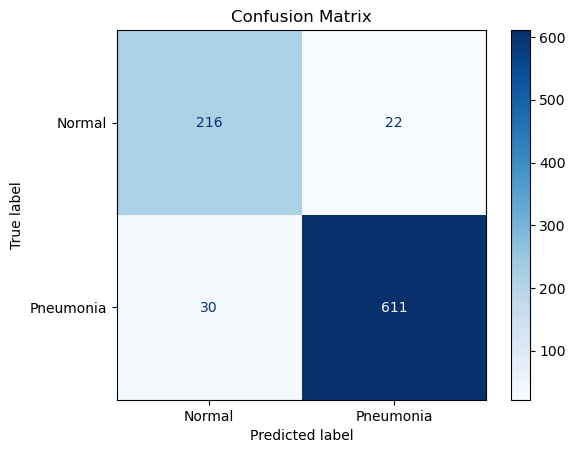

In [21]:
def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

# Plot ROC/AUC Score

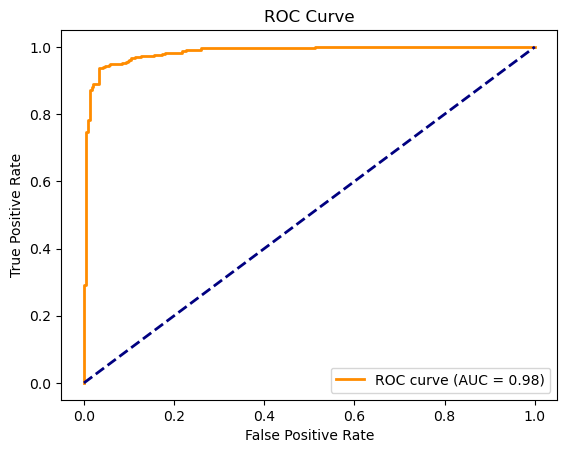

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(model, model.test_loader)

# Plot Gradcam

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024B3A754F40>
Traceback (most recent call last):
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\utils\data\dataloader.py", line 1563, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\utils\data\dataloader.py", line 1499, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


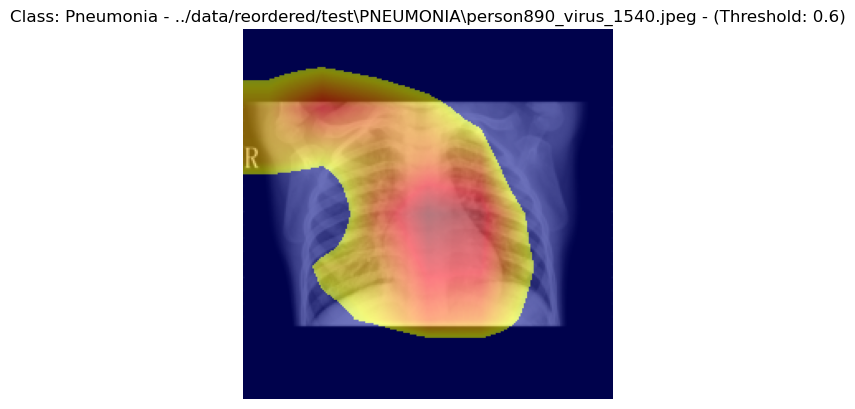

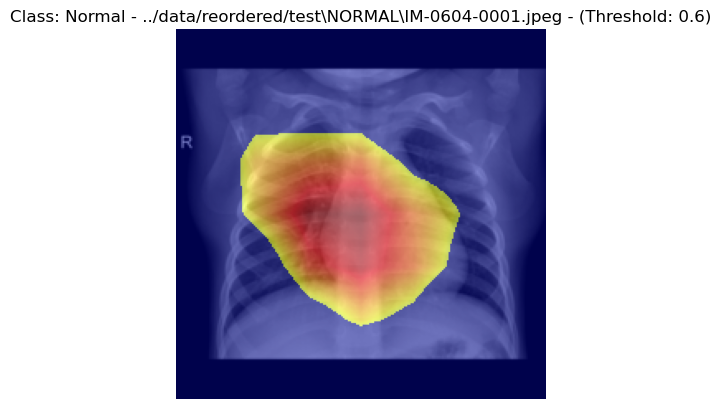

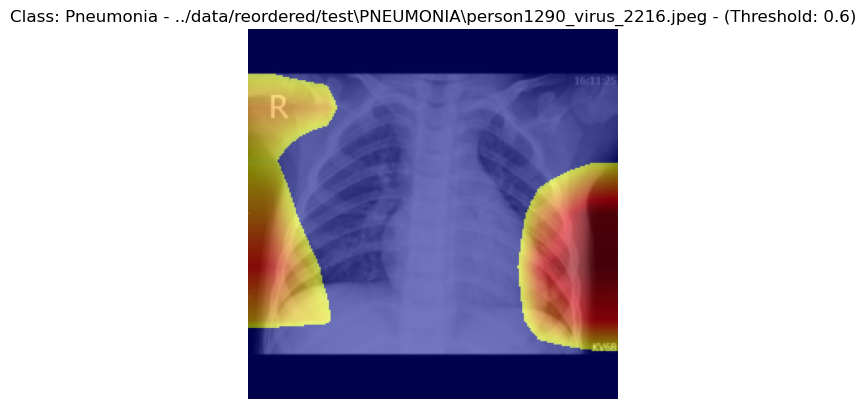

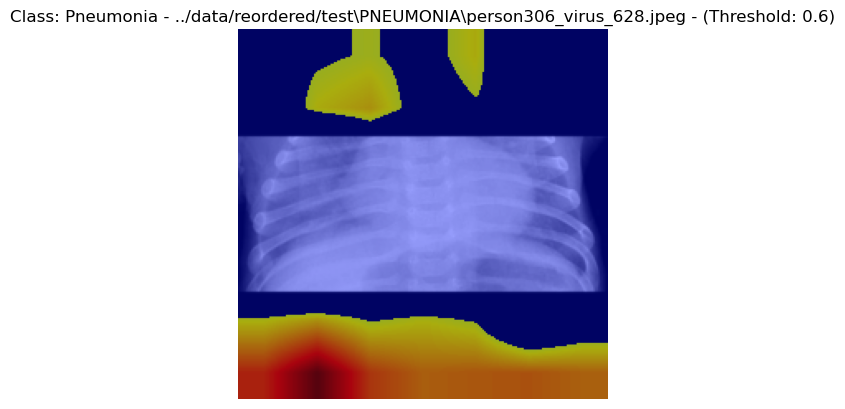

In [23]:
for param in model.feature_extractor.parameters():
    param.requires_grad = True
model.visualize_gradcam(num_samples=4, target_layer=7, class_names=["Normal", "Pneumonia"], threshold=0.6)


# Evaluate Metrics in Tensorboard

In [24]:
# Load TensorBoard extension
%load_ext tensorboard

# Specify the log directory
log_dir = f"tb_logs/{config.model_name}"

# Start TensorBoard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Classify random images

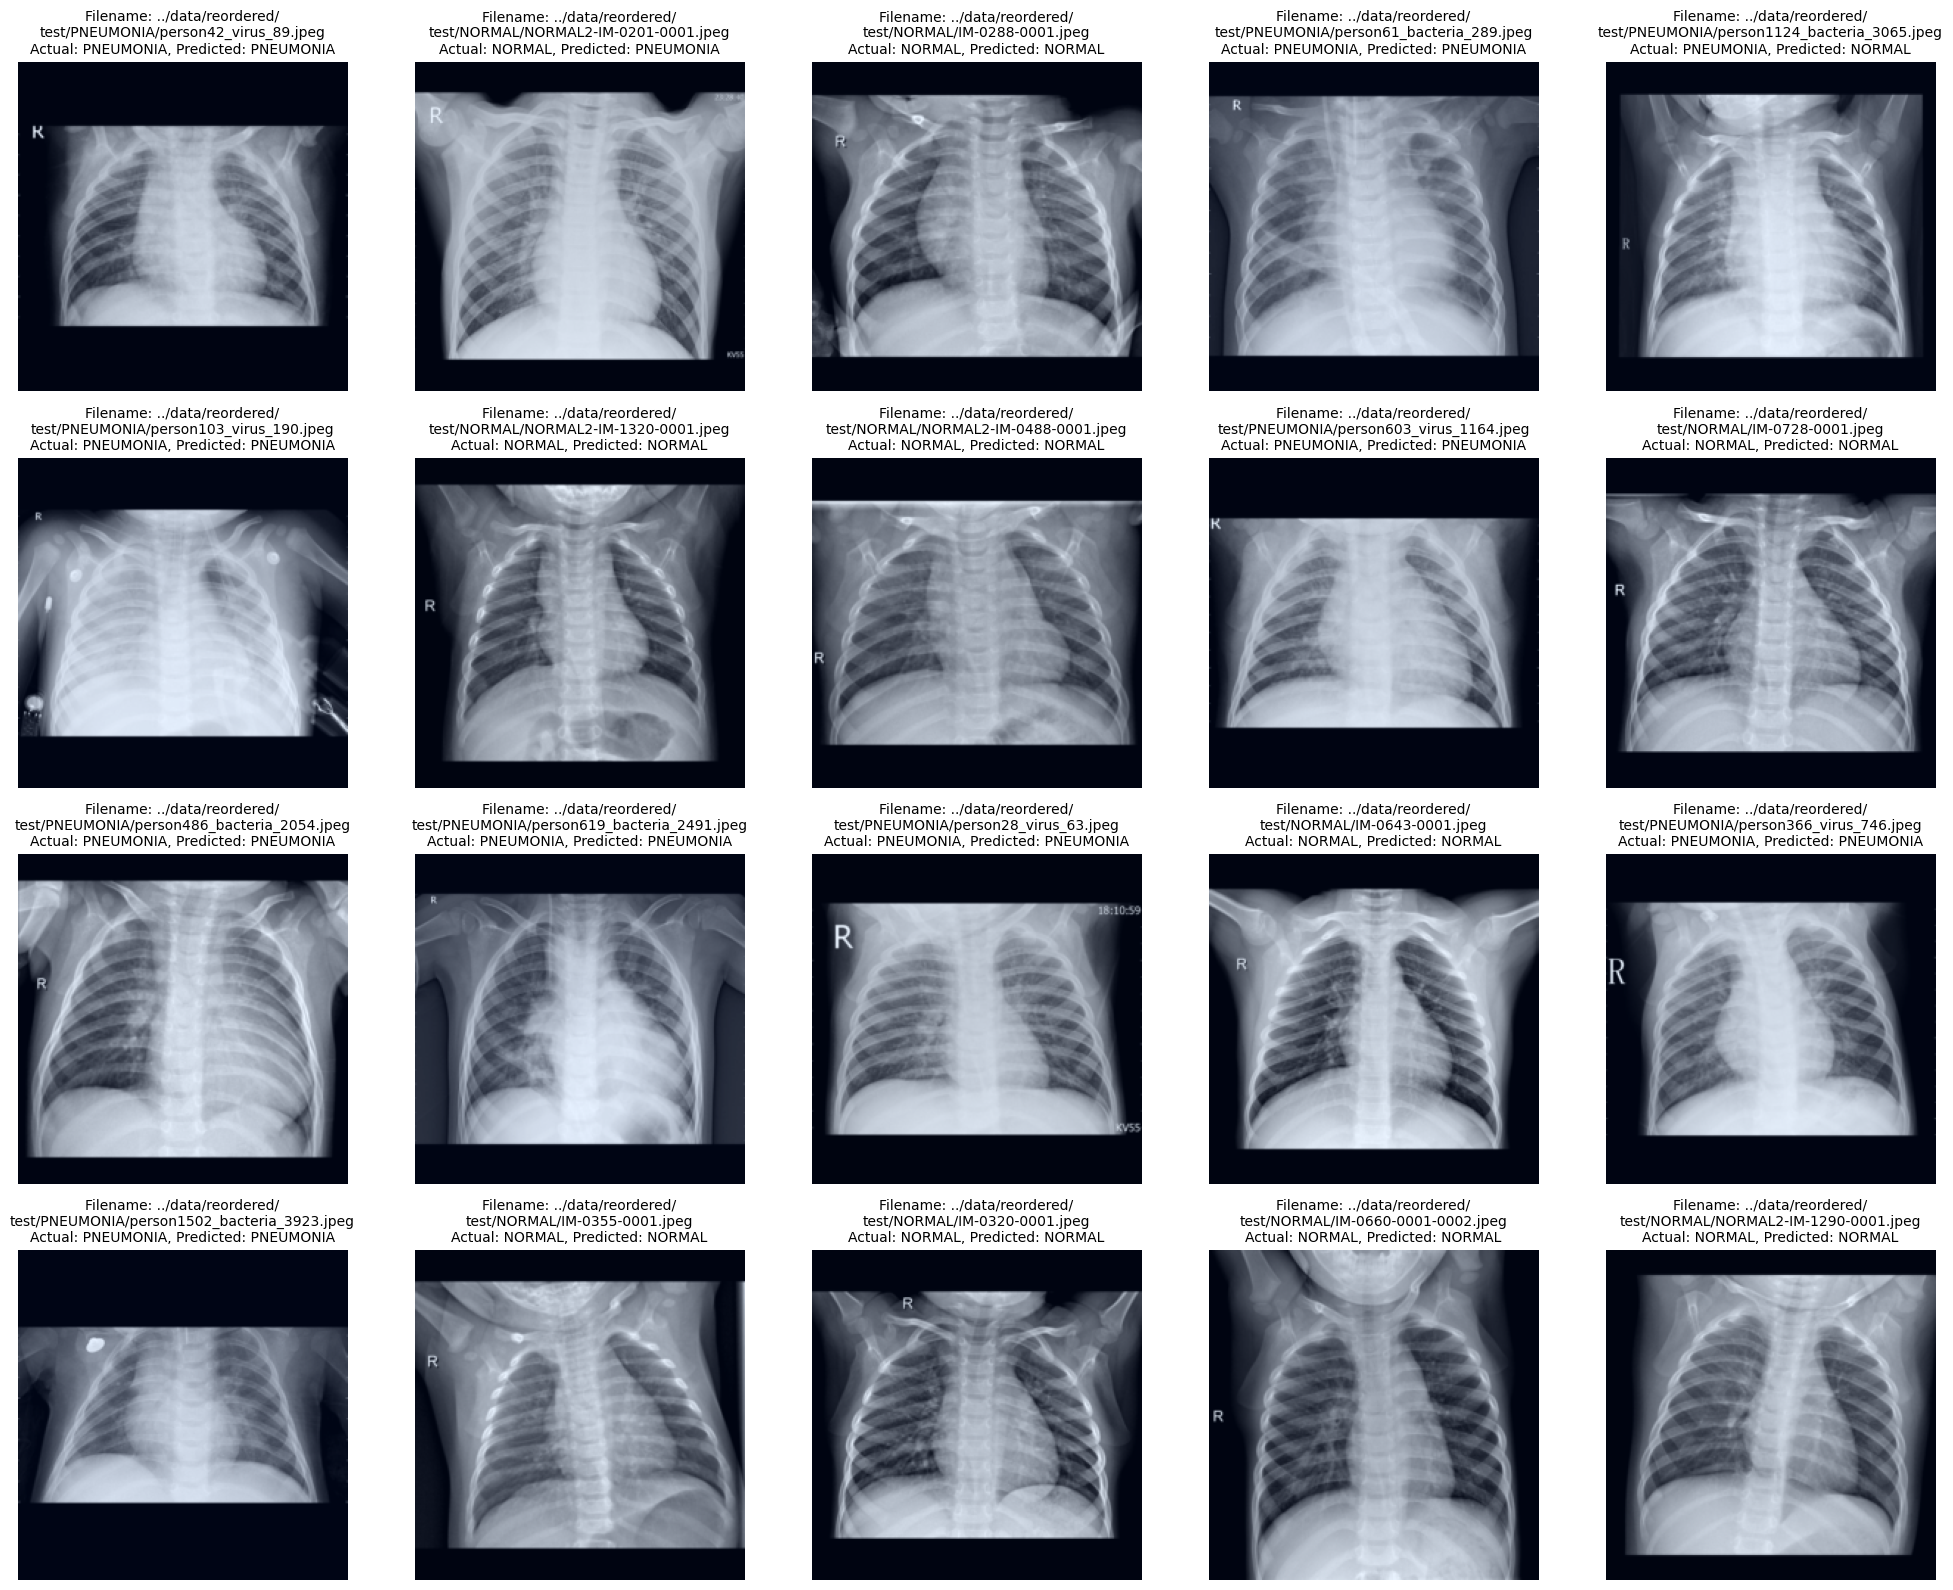

In [25]:
plot_random_images_with_labels(model, model.test_loader, num_images=20)